In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install stable-baselines3
!pip install shimmy>=0.2.1
!pip install gymnasium==0.28.1
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import MinMaxScaler
import torch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0a2 which is incompatible.
  Using cached gymnasium-0.28.1-py3-none-any.whl.metadata (9.2 kB)
Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.28.1 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
# from stable_baselines3.common.utils import set_random_seed

technical_data = pd.read_csv('/content/gdrive/My Drive/NIFTY50_all.csv')
fundamental_data = pd.read_excel('/content/gdrive/My Drive/quarterly results.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
technical_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741


In [7]:
# setting seed everywhere for duplication of results

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#set_random_seed(seed)

In [8]:
# dropping columns that are not necessary for our analyis at all

dropping_columns = ['Series', 'Turnover', 'Prev Close', 'Last', 'Trades', 'Deliverable Volume', 'VWAP', 'Open', 'High', 'Low', 'Volume', '%Deliverble']


# dropping unnecessary columns using axis=1
technical_data = technical_data.drop(dropping_columns, axis=1)
technical_data.head()

,Date,Symbol,Close
0,2007-11-27,MUNDRAPORT,962.90
1,2007-11-28,MUNDRAPORT,893.90
2,2007-11-29,MUNDRAPORT,884.20
3,2007-11-30,MUNDRAPORT,921.55
4,2007-12-03,MUNDRAPORT,969.30


In [9]:
technical_data['Symbol'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['MUNDRAPORT', 'ADANIPORTS', 'ASIANPAINT', 'UTIBANK', 'AXISBANK',
       'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJAUTOFIN', 'BAJFINANCE', 'BHARTI',
       'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY',
       'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH', 'HDFC', 'HDFCBANK',
       'HEROHONDA', 'HEROMOTOCO', 'HINDALC0', 'HINDALCO', 'HINDLEVER',
       'HINDUNILVR', 'ICICIBANK', 'INDUSINDBK', 'INFOSYSTCH', 'INFY',
       'IOC', 'ITC', 'JSWSTL', 'JSWSTEEL', 'KOTAKMAH', 'KOTAKBANK', 'LT',
       'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID',
       'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA', 'TELCO', 'TATAMOTORS',
       'TISCO', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UNIPHOS', 'UPL', 'SESAGOA', 'SSLT', 'VEDL', 'WIPRO', 'ZEETELE',
       'ZEEL'], dtype=object)

In [10]:
technical_data['Symbol'].nunique()

65

In [11]:
# these stocks overlap in the manner that the replacements either acquired the replaced stocks or they had a change of name

replacements = {'MUNDRAPORT': 'ADANIPORTS',
                'UTIBANK': 'AXISBANK',
                'BAJAUTOFIN': 'BAJFINANCE',
                'BHARTI': 'BHARTIARTL',
                'HEROHONDA':'HEROMOTOCO',
                'HINDALC0':'HINDALCO',
                'HINDLEVER':'HINDUNILVR',
                'KOTAKMAH':'KOTAKBANK',
                'INFOSYSTCH':'INFY',
                'JSWSTL':'JSWSTEEL',
                'ZEETELE':'ZEEL',
                'TELCO':'TATAMOTORS',
                'TISCO':'TATASTEEL',
                'UNIPHOS':'UPL',
                'SESAGOA':'VEDL',
                'SSLT':'VEDL'}

# replace multiple values using the dictionary created above
technical_data['Symbol'] = technical_data['Symbol'].replace(replacements)

# this stock is dropped since it merged with HDFCBANK and changed the price completely and
# the results are not accounted for so it best to drop
stocks_to_drop = ['HDFC']

technical_data = technical_data[~technical_data['Symbol'].isin(stocks_to_drop)]
technical_data['Symbol'].unique()

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK',
       'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT',
       'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID',
       'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA', 'TATAMOTORS',
       'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'UPL', 'VEDL',
       'WIPRO', 'ZEEL'], dtype=object)

In [12]:
# checking the unique number of stocks left
technical_data['Symbol'].nunique()

48

In [13]:
#converting date column to date format
technical_data['Date'] = pd.to_datetime(technical_data['Date'])

#extracting month name for filtering further down the line
technical_data['Month'] = technical_data['Date'].dt.month
technical_data['Year'] = technical_data['Date'].dt.year

# sorting the dataset by Date
technical_data = technical_data.sort_values(by=['Date'])

# multiplying deliverable_pct by 100 to get percent and see if it is worthy of usage somewhere
# technical_data['Deliverable_pct'] = technical_data['%Deliverble']*100
technical_data.head()
#technical_data.info()

,Date,Symbol,Close,Month,Year
54167,2000-01-03,EICHERMOT,48.85,1,2000
192462,2000-01-03,TATASTEEL,152.45,1,2000
40957,2000-01-03,CIPLA,1457.35,1,2000
219275,2000-01-03,VEDL,116.35,1,2000
176865,2000-01-03,SHREECEM,64.75,1,2000


In [14]:
technical_data.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
Date,0
Symbol,0
Close,0
Month,0
Year,0


In [15]:
# dropping it since new column using this has been created
# technical_data = technical_data.drop('%Deliverble', axis=1)


In [16]:
# calculating the 50_DMA, 200_DMA, and 14_DRSI using standard calculations

technical_data['50_dma'] = technical_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=50).mean())
technical_data['200_dma'] = technical_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=200).mean())
def rsi_calculation(series, period):
    delta_rsi = series.diff()
    gain = (delta_rsi.where(delta_rsi > 0, 0)).rolling(window=period).mean()
    loss = (-delta_rsi.where(delta_rsi < 0, 0)).rolling(window=period).mean()
    rel_strength = gain / loss
    rsi = 100 - (100 / (1 + rel_strength))
    return rsi

technical_data['14_DRSI'] = technical_data.groupby('Symbol')['Close'].transform(lambda x: rsi_calculation(x, 14))

In [17]:
# resetting index and then filtering the data to quarterly basis on the month adn year range 2010-2020

technical_data = technical_data.groupby(['Year', 'Month', 'Symbol']).first().reset_index()
years_to_keep = range(2010,2021) #2021 not included as last limit not included
months_to_keep = [1, 4, 7, 10]
technical_data = technical_data[technical_data['Year'].isin(years_to_keep)]
technical_data = technical_data[technical_data['Month'].isin(months_to_keep)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# calculating the quarterly percent change as well as the log change to calculate sharpe ratios and multiplying by 100 for percentage

technical_data['quarterly_percent_price_change'] = technical_data.groupby('Symbol')['Close'].pct_change() * 100
technical_data['quarterly_price_log_change'] = np.log(1 + technical_data['quarterly_percent_price_change'] / 100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# portfolio rebalancing decisions to be taken at the end of every quarter so 1st month Jan becomes Q3 as Q3 ends in December in India

month_to_quarter = {1: 'Q3', 4: 'Q4', 7: 'Q1', 10: 'Q2'
                }

# mapping months to quarter name for merging data later
technical_data['Quarter'] = technical_data['Month'].map(month_to_quarter)
# technical_data['Month'] = technical_data['Month'].astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# removing year 2010 as one of the stocks was not yet listed till the end of 2010 and imputing null values in financial dataset would ruin the flow of data
technical_data = technical_data[technical_data['Year']!=2010]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading and working on the fundamental data now

In [21]:
fundamental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Symbol                                2112 non-null   object 
 1   Year                                  2112 non-null   int64  
 2   Month                                 2112 non-null   object 
 3   Basic EPS (Rs.)                       2111 non-null   float64
 4   Net Profit/Loss For the Period (Cr.)  2111 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 82.6+ KB


In [22]:
fundamental_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Symbol,Year,Month,Basic EPS (Rs.),Net Profit/Loss For the Period (Cr.)
0,ADANIPORTS,2020,December,3.06,622.55
1,ADANIPORTS,2020,September,3.42,695.72
2,ADANIPORTS,2020,June,1.41,286.58
3,ADANIPORTS,2020,March,2.46,500.29
4,ADANIPORTS,2019,December,2.26,458.93


In [23]:
# fundamental replacements from month name to month number as this data was manually collected
# and then mapping the month to the quarter name

replacements_fundamental = {'December': 12,
                'March': 3,
                'June': 6,
                'September': 9
                }
month_to_quarter_fundamentals = {12: 'Q3',
                3: 'Q4',
                6: 'Q1',
                9: 'Q2'
                }

# Replace multiple values using the dictionary
fundamental_data['Month'] = fundamental_data['Month'].replace(replacements_fundamental)
fundamental_data['Quarter'] = fundamental_data['Month'].map(month_to_quarter_fundamentals)
fundamental_data['Quarter'] = fundamental_data['Quarter'].astype(str)
fundamental_data['Year'] = fundamental_data['Year'].astype(int)
fundamental_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Symbol,Year,Month,Basic EPS (Rs.),Net Profit/Loss For the Period (Cr.),Quarter
0,ADANIPORTS,2020,12,3.06,622.55,Q3
1,ADANIPORTS,2020,9,3.42,695.72,Q2
2,ADANIPORTS,2020,6,1.41,286.58,Q1
3,ADANIPORTS,2020,3,2.46,500.29,Q4
4,ADANIPORTS,2019,12,2.26,458.93,Q3


In [24]:
# sorting by year and month to calculate the eps and profit percent change for each stock
fundamental_data = fundamental_data.sort_values(by=['Year', 'Month'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# calculating percentage change for both parameters
fundamental_data['quarterly_eps_change'] = fundamental_data.groupby('Symbol')['Basic EPS (Rs.)'].pct_change() * 100
fundamental_data['quarterly_profit_change'] = fundamental_data.groupby('Symbol')['Net Profit/Loss For the Period (Cr.)'].pct_change() * 100

<ipython-input-25-b73349a25bcf>:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fundamental_data['quarterly_eps_change'] = fundamental_data.groupby('Symbol')['Basic EPS (Rs.)'].pct_change() * 100
<ipython-input-25-b73349a25bcf>:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fundamental_data['quarterly_profit_change'] = fundamental_data.groupby('Symbol')['Net Profit/Loss For the Period (Cr.)'].pct_change() * 100


In [26]:
# combining technical and fundamental data together based on year quarter and symbol
combined_data = pd.merge(technical_data, fundamental_data, on=['Year', 'Quarter', 'Symbol'])
combined_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Year,Month_x,Symbol,Date,Close,50_dma,200_dma,14_DRSI,quarterly_percent_price_change,quarterly_price_log_change,Quarter,Month_y,Basic EPS (Rs.),Net Profit/Loss For the Period (Cr.),quarterly_eps_change,quarterly_profit_change
0,2011,1,ADANIPORTS,2011-01-03,145.05,150.189,532.99000,44.539249,-13.169710,-0.141215,Q3,12,1.55,310.60,13.970588,13.598127
1,2011,1,ASIANPAINT,2011-01-03,2874.55,2706.086,2481.25350,65.887097,7.883280,0.075880,Q3,12,26.11,250.48,27.677262,17.651480
2,2011,1,AXISBANK,2011-01-03,1367.65,1401.140,1337.75550,59.415064,-13.156809,-0.141066,Q3,12,26.73,1102.27,19.704433,19.770297
3,2011,1,BAJAJ-AUTO,2011-01-03,1476.50,1537.996,2010.77025,45.425938,-4.584962,-0.046934,Q3,12,27.50,795.19,9.561753,9.560485
4,2011,1,BAJAJFINSV,2011-01-03,470.40,467.411,447.60150,57.909605,-10.706150,-0.113238,Q3,12,1.00,14.47,-65.517241,-65.604944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2020,10,ULTRACEMCO,2020-10-01,4097.75,3995.599,3916.36550,64.058076,5.108244,0.049821,Q2,9,41.90,1208.67,50.017902,50.039103
1916,2020,10,UPL,2020-10-01,505.65,494.891,467.10550,52.910284,13.133460,0.123398,Q2,9,1.36,104.00,-30.256410,-30.201342
1917,2020,10,VEDL,2020-10-01,137.45,126.751,115.39125,59.113300,27.623027,0.243911,Q2,9,1.02,378.00,-87.202008,-87.246964
1918,2020,10,WIPRO,2020-10-01,313.05,287.043,236.39350,67.649687,42.912577,0.357063,Q2,9,3.94,2244.00,2.337662,2.344249


In [27]:
# checking integrity for null value replacements
combined_data['Symbol'].value_counts()
combined_data.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
Year,0
Month_x,0
Symbol,0
Date,0
Close,0
50_dma,0
200_dma,3
14_DRSI,0
quarterly_percent_price_change,1
quarterly_price_log_change,1


In [28]:
# checking which rows are empty and for which stock
missing_in_200dma = combined_data[combined_data['200_dma'].isna()]
missing_in_quarterly_price_change = combined_data[combined_data['quarterly_percent_price_change'].isna()]
print(missing_in_quarterly_price_change)
print(missing_in_200dma)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    Year  Month_x     Symbol       Date  Close  50_dma  200_dma    14_DRSI  \
10  2011        1  COALINDIA 2011-01-03  317.3  318.33      NaN  43.937824   

    quarterly_percent_price_change  quarterly_price_log_change Quarter  \
10                             NaN                         NaN      Q3   

    Month_y  Basic EPS (Rs.)  Net Profit/Loss For the Period (Cr.)  \
10       12             1.93                               1219.33   

    quarterly_eps_change  quarterly_profit_change  
10             12.865497                12.831973  
     Year  Month_x     Symbol       Date   Close   50_dma  200_dma    14_DRSI  \
10   2011        1  COALINDIA 2011-01-03  317.30  318.330      NaN  43.937824   
58   2011        4  COALINDIA 2011-04-01  346.90  322.909      NaN  60.737705   
106  2011        7  COALINDIA 2011-07-01  384.25  386.542      NaN  41.961308   

     quarterly_percent_price_change  quarterly_price_log_change Quarter  \
10                              NaN              

In [29]:
# filling with na because there is no better imputation method that won't hamper the results
# better imputations can be explored
combined_data = combined_data.fillna(0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
print(combined_data.shape)

(1920, 16)


In [31]:
# giving score for each parameter depending upon values of parameters
# dma is bullish if 50 crosses 200 and stays up
combined_data['dma_signal'] = np.where(combined_data['50_dma'] > combined_data['200_dma'], 1, 0)
combined_data['rsi_signal'] = np.where(combined_data['14_DRSI'] > 50, 1, 0)

# positive eps and profit indicate good financial health and hence score of 1 if true
# fundamental_technical_score is just the sum of all the scores for a stock for each date
combined_data['eps_signal'] = np.where(combined_data['quarterly_eps_change'] > 0, 1, 0)
combined_data['profit_signal'] = np.where(combined_data['quarterly_profit_change'] > 0, 1, 0)
combined_data['fundamental_technical_score'] = combined_data['dma_signal'] + combined_data['rsi_signal'] + combined_data['eps_signal'] + combined_data['profit_signal']
combined_data.head(50)

,Year,Month_x,Symbol,Date,Close,50_dma,200_dma,14_DRSI,quarterly_percent_price_change,quarterly_price_log_change,...,Month_y,Basic EPS (Rs.),Net Profit/Loss For the Period (Cr.),quarterly_eps_change,quarterly_profit_change,dma_signal,rsi_signal,eps_signal,profit_signal,fundamental_technical_score
0,2011,1,ADANIPORTS,2011-01-03,145.05,150.189,532.99000,44.539249,-13.169710,-0.141215,...,12,1.55,310.60,13.970588,13.598127,0,0,1,1,2
1,2011,1,ASIANPAINT,2011-01-03,2874.55,2706.086,2481.25350,65.887097,7.883280,0.075880,...,12,26.11,250.48,27.677262,17.651480,1,1,1,1,4
2,2011,1,AXISBANK,2011-01-03,1367.65,1401.140,1337.75550,59.415064,-13.156809,-0.141066,...,12,26.73,1102.27,19.704433,19.770297,1,1,1,1,4
3,2011,1,BAJAJ-AUTO,2011-01-03,1476.50,1537.996,2010.77025,45.425938,-4.584962,-0.046934,...,12,27.50,795.19,9.561753,9.560485,0,0,1,1,2
4,2011,1,BAJAJFINSV,2011-01-03,470.40,467.411,447.60150,57.909605,-10.706150,-0.113238,...,12,1.00,14.47,-65.517241,-65.604944,1,1,0,0,2
5,2011,1,BAJFINANCE,2011-01-03,704.75,739.613,595.05550,53.784119,-9.058649,-0.094955,...,12,32.76,119.99,37.358491,37.335470,1,1,1,1,4
6,2011,1,BHARTIARTL,2011-01-03,359.35,336.038,314.47700,71.462264,-1.574911,-0.015874,...,12,3.73,1416.00,8.430233,8.298279,1,1,1,1,4
7,2011,1,BPCL,2011-01-03,659.95,703.142,649.51200,41.618497,-12.658814,-0.135348,...,12,86.84,3139.60,-197.223466,-197.223211,1,0,0,0,1
8,2011,1,BRITANNIA,2011-01-03,409.35,409.301,1252.15150,54.416961,-6.252147,-0.064561,...,12,4.53,54.07,42.902208,42.853369,0,1,1,1,3
9,2011,1,CIPLA,2011-01-03,372.50,354.142,333.19650,67.484663,15.040148,0.140111,...,12,3.37,269.91,-12.467532,-12.642004,1,1,0,0,2


In [32]:
combined_data.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Year                                  1920 non-null   int32         
 1   Month_x                               1920 non-null   int32         
 2   Symbol                                1920 non-null   object        
 3   Date                                  1920 non-null   datetime64[ns]
 4   Close                                 1920 non-null   float64       
 5   50_dma                                1920 non-null   float64       
 6   200_dma                               1920 non-null   float64       
 7   14_DRSI                               1920 non-null   float64       
 8   quarterly_percent_price_change        1920 non-null   float64       
 9   quarterly_price_log_change            1920 non-null   float64       
 10  

In [33]:
print(combined_data.shape)

(1920, 21)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# writing to csv to make sure everything looks good and for ease of access if lost
# checkpoint
combined_data.to_csv('/content/gdrive/My Drive/combined_data.csv', index=False)

EDA of Data

In [35]:
# performing shapiro-wilk test to test for normality of quarterly_price_change distribution

shapiro_wilk_results = {}

for symbol, group in combined_data.groupby('Symbol'):
    shapiro_test = stats.shapiro(group['quarterly_percent_price_change'])
    shapiro_wilk_results[symbol] = {'p-value': shapiro_test[1]}

# converting the results to a dataframe
shapiro_results_quarterly_df = pd.DataFrame(shapiro_wilk_results).T

# sort by p-value to get the normally distributed stocks first
shapiro_results_df = shapiro_results_quarterly_df.sort_values(by='p-value', ascending=False)

# display the dataframe
# normally distributed is p > 0.05
shapiro_results_df

,p-value
TATASTEEL,9.643869e-01
LT,8.009980e-01
ADANIPORTS,7.452067e-01
WIPRO,7.026563e-01
DRREDDY,6.865168e-01
MARUTI,6.817935e-01
NESTLEIND,5.152019e-01
HINDALCO,4.685539e-01
ULTRACEMCO,4.371418e-01
COALINDIA,4.174852e-01


In [36]:
# analyzing the percentage of stocks that are not normally distributed
# p value should be less than 0.05
total_stocks = shapiro_results_df.shape[0]

# counting the number of stocks with p-value < 0.05
non_normally_distributed_stocks = shapiro_results_df[shapiro_results_df['p-value'] < 0.05].shape[0]

# calculate percentage of stocks not normally distributed
percentage_non_normally_distributed = (non_normally_distributed_stocks / total_stocks) * 100

percentage_non_normally_distributed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


45.83333333333333

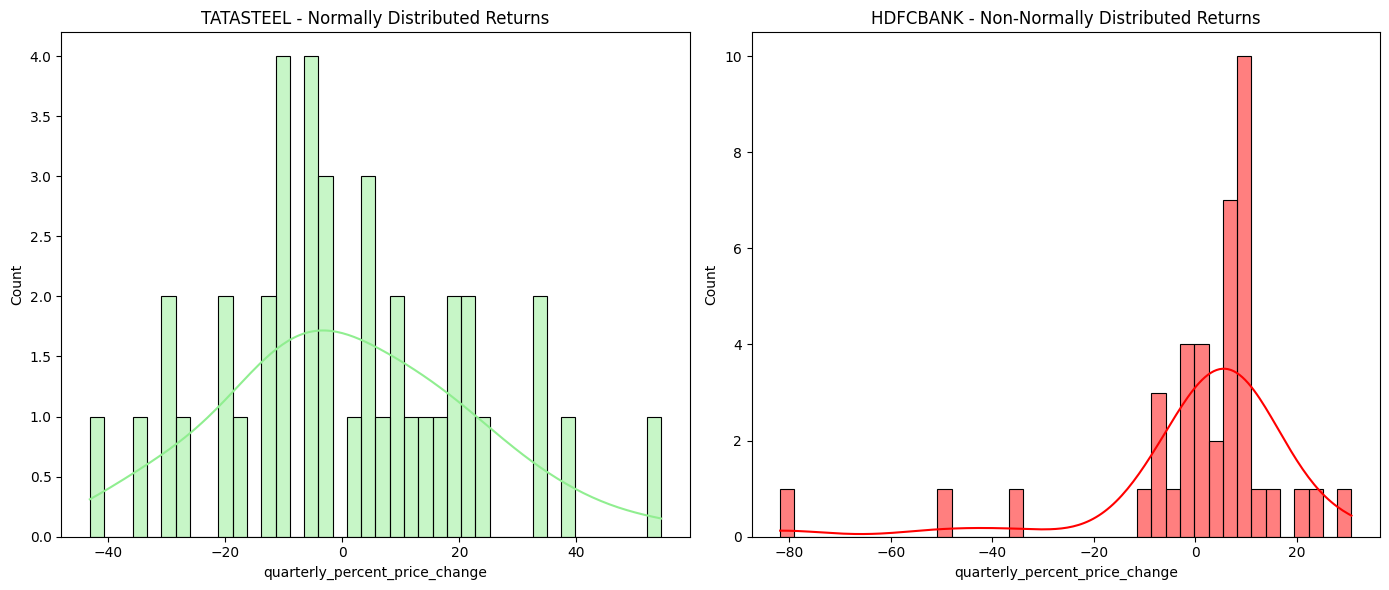

In [37]:
# selecting stocks with normal distribution as well as non-normal distribution for graphs
normally_distributed_stock_example = shapiro_results_df[shapiro_results_df['p-value'] > 0.05].index[0]
non_normally_distributed_stock_example = shapiro_results_df[shapiro_results_df['p-value'] < 0.05].index[-1]

# ploting histograms for above chosen stocks using quarterly_percent_price_change
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# normally distributed stock
sns.histplot(combined_data[combined_data['Symbol'] == normally_distributed_stock_example]['quarterly_percent_price_change'], bins=40, kde=True, color='lightgreen', ax=axes[0])
axes[0].set_title(f'{normally_distributed_stock_example} - Normally Distributed Returns')

# Non-normally distributed stock
sns.histplot(combined_data[combined_data['Symbol'] == non_normally_distributed_stock_example]['quarterly_percent_price_change'], bins=40, kde=True, color = 'red', ax=axes[1])
axes[1].set_title(f'{non_normally_distributed_stock_example} - Non-Normally Distributed Returns')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-38-d226116590fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['next_quarter_close'] = stock_data.groupby('Symbol')['Close'].shift(-1)
<ipython-input-38-d226116590fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

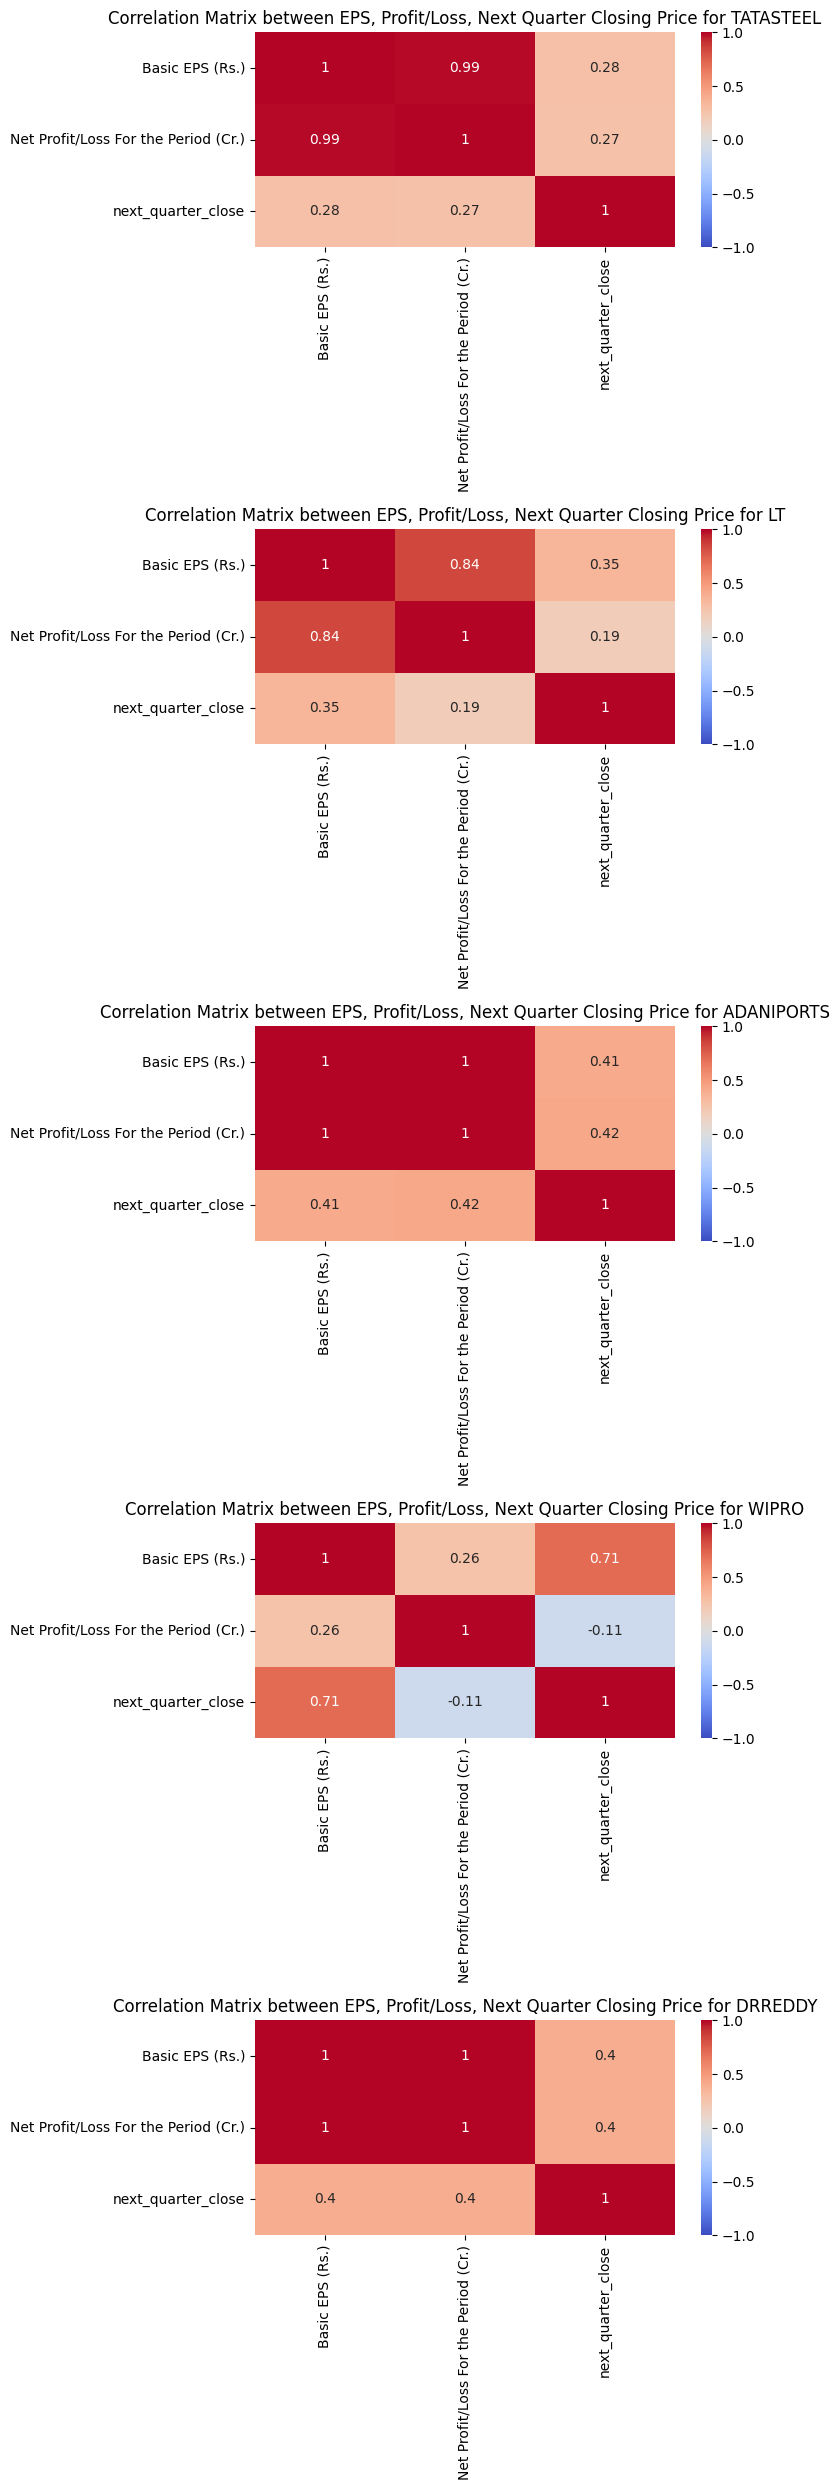

In [38]:
# we should also check whether or not the EPS and Profit/Loss are correlated with the movement of the price at all
# closing price is used for the next quarter because once the results are out, we assume that the closing price of the next quarter will show the effects if any
correlation_matrices_close = {}

# list of 5 randomly selected stocks; used fixed for replication of results
sample_stocks_eda = shapiro_results_df.index[:5]

for stock in sample_stocks_eda:
    stock_data = combined_data[combined_data['Symbol'] == stock]
    # creating next quarter close because the results will be best shown with close of next quarter
    stock_data['next_quarter_close'] = stock_data.groupby('Symbol')['Close'].shift(-1)
    corr_matrix = stock_data[['Basic EPS (Rs.)', 'Net Profit/Loss For the Period (Cr.)', 'next_quarter_close']].corr()
    correlation_matrices_close[stock] = corr_matrix

fig, axes = plt.subplots(5, 1, figsize=(8, 25))

for i, (stock, corr_matrix) in enumerate(correlation_matrices_close.items()):
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[i], vmin=-1, vmax=1, center=0)
    axes[i].set_title(f'Correlation Matrix between EPS, Profit/Loss, Next Quarter Closing Price for {stock}')
    axes[i].set_ylim([3, 0])

plt.tight_layout()
plt.show()


Implementation of MCS with guidance

In [39]:
num_portfolios = 200000
quarter_best_portfolios = []
risk_free_rate = 0.0 # ease of understanding

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
for i in range(len(combined_data['Date'].unique()) - 1):
    # Get the current and next quarter's data
    # Extracting current quarter data and next quarter data for portfolio return calculation
    quarter_date = combined_data['Date'].unique()[i]
    next_quarter_date = combined_data['Date'].unique()[i + 1]

    # Extracting data for current quarter and next quarter for cov and returns calculations
    quarter_data = combined_data[combined_data['Date'] == quarter_date].set_index('Symbol')
    next_quarter_data = combined_data[combined_data['Date'] == next_quarter_date].set_index('Symbol')

    # creating covariance matrices for returns in next quarter and the cov matrix
    log_return_matrix = next_quarter_data['quarterly_price_log_change'].values.reshape(-1, 1)
    cov_matrix = np.cov(log_return_matrix, rowvar=False)

    # initialize arrays to store the results of simulations
    portfolio_returns = []
    portfolio_volatilities = []
    sharpe_ratios = []
    stock_weightages = []

    # extracting symbols in quarter
    symbols_in_quarter = quarter_data.index.values

    # Monte Carlo Simulation for this Date (quarter end)
    for x in range(num_portfolios):
        # generating random weights for initialization
        random_weights = np.random.random(len(symbols_in_quarter))

        # adjusting the weights according to the technical and fundamental score
        adjusted_weights = random_weights * quarter_data['fundamental_technical_score'].values

        # normalizing the sum so the total weight of the portfolio is always 100% or 1
        adjusted_weights = adjusted_weights / np.sum(adjusted_weights)

        # portfolio return by multiplying the chosen stocks and weights by performance/returns in next quarter
        portfolio_log_return = np.sum(adjusted_weights * next_quarter_data['quarterly_price_log_change'].values)

        # converting claculated log returns to simple returns for ease of understanding
        # for future visualization as well
        portfolio_simple_return = np.exp(portfolio_log_return) - 1

        # portfolio volatility calculation using cov matrix for sharpe ratio calculation
        portfolio_volatility = np.sqrt(np.dot(adjusted_weights, np.dot(cov_matrix, adjusted_weights)))

        # calculate sharpe ratio using log returns
        # https://quant.stackexchange.com/questions/1102/should-sharpe-ratio-be-computed-using-log-returns-or-relative-returns
        sharpe_ratio = (portfolio_log_return - risk_free_rate) / portfolio_volatility

        # storing results for further extraction later on
        portfolio_returns.append(portfolio_simple_return)
        portfolio_volatilities.append(portfolio_volatility)
        sharpe_ratios.append(sharpe_ratio)
        stock_weightages.append(adjusted_weights)

    # convert lists to numpy arrays for easy management
    portfolio_returns = np.array(portfolio_returns)
    portfolio_volatilities = np.array(portfolio_volatilities)
    sharpe_ratios = np.array(sharpe_ratios)
    stock_weightages = np.array(stock_weightages)

    # identify the best portfolio for running quarter
    max_sharpe_portfolio_index = sharpe_ratios.argmax()
    best_portfolio_weights = stock_weightages[max_sharpe_portfolio_index]
    best_portfolio_return = portfolio_returns[max_sharpe_portfolio_index]
    best_portfolio_volatility = portfolio_volatilities[max_sharpe_portfolio_index]
    best_sharpe_ratio = sharpe_ratios[max_sharpe_portfolio_index]

    # Store the best portfolio details for running quarter in loop
    most_efficient_portfolio = {
        'Date': quarter_date,
        'Best Weights': best_portfolio_weights,
        'Return': best_portfolio_return,
        'Volatility': best_portfolio_volatility,
        'Sharpe Ratio': best_sharpe_ratio,
        'Symbols': symbols_in_quarter
    }

    quarter_best_portfolios.append(most_efficient_portfolio)


In [41]:
last_9_portfolios = quarter_best_portfolios[-9:]

# extract values
dates_mcs = [portfolio['Date'] for portfolio in last_9_portfolios]
sharpe_ratios_mcs = [portfolio['Sharpe Ratio'] for portfolio in last_9_portfolios]
returns_mcs = [portfolio['Return'] for portfolio in last_9_portfolios]
volatilities_mcs = [portfolio['Volatility'] for portfolio in last_9_portfolios]

# create a DataFrame
last_9_portfolios_mcs = pd.DataFrame({
    'Date': dates_mcs,
    'Sharpe Ratio': sharpe_ratios_mcs,
    'Return': returns_mcs,
    'Volatility': volatilities_mcs
})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# for the sake of comparison of last 9 portfolios with rl algorithm
# all factors to be compared apart from weight distribution of stocks

last_9_portfolios_mcs

,Date,Sharpe Ratio,Return,Volatility
0,2018-07-02,2.307614,0.070530,0.029534
1,2018-10-01,0.883746,0.028199,0.031467
2,2019-01-01,3.854532,0.075544,0.018894
3,2019-04-01,3.431757,0.069071,0.019462
4,2019-07-01,-0.570697,-0.025171,0.044670
5,2019-10-01,3.395717,0.105116,0.029434
6,2020-01-01,-5.858832,-0.295303,0.059737
7,2020-04-01,9.296695,0.355226,0.032696
8,2020-07-01,1.825364,0.139330,0.071460


In [43]:
# Extract the portfolios with maximum and minimum Sharpe ratio, and maximum and minimum volatility
max_sharpe_portfolio = max(quarter_best_portfolios, key=lambda x: x['Sharpe Ratio'])
min_sharpe_portfolio = min(quarter_best_portfolios, key=lambda x: x['Sharpe Ratio'])
max_volatility_portfolio = max(quarter_best_portfolios, key=lambda x: x['Volatility'])
min_volatility_portfolio = min(quarter_best_portfolios, key=lambda x: x['Volatility'])

# Print the dates of these portfolios
print("Portfolio with Maximum Sharpe Ratio Date:", max_sharpe_portfolio['Date'])
print("Portfolio with Minimum Sharpe Ratio Date:", min_sharpe_portfolio['Date'])
print("Portfolio with Maximum Volatility Date:", max_volatility_portfolio['Date'])
print("Portfolio with Minimum Volatility Date:", min_volatility_portfolio['Date'])

# Function to extract stocks with non-zero weight and their corresponding weights
def extract_stock_with_non_zero_weights(portfolio):
    non_zero_weight_stocks = {symbol: weight for symbol, weight in zip(portfolio['Symbols'], portfolio['Best Weights']) if weight > 0}
    return pd.DataFrame(list(non_zero_weight_stocks.items()), columns=['Stock', 'Weight'])

# Extract the non-zero weight stocks for each of the four portfolios
max_sharpe_protfolio_stocks = extract_stock_with_non_zero_weights(max_sharpe_portfolio)
min_sharpe_portfolio_stocks = extract_stock_with_non_zero_weights(min_sharpe_portfolio)
max_volatility_stocks = extract_stock_with_non_zero_weights(max_volatility_portfolio)
min_volatility_portfolio_stocks = extract_stock_with_non_zero_weights(min_volatility_portfolio)

Portfolio with Maximum Sharpe Ratio Date: 2014-04-01 00:00:00
Portfolio with Minimum Sharpe Ratio Date: 2020-01-01 00:00:00
Portfolio with Maximum Volatility Date: 2011-04-01 00:00:00
Portfolio with Minimum Volatility Date: 2012-04-02 00:00:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
quarter_best_portfolios

[{'Date': Timestamp('2011-01-03 00:00:00'),
  'Best Weights': array([0.0083257 , 0.03623785, 0.01378192, 0.01020952, 0.02858027,
         0.05415359, 0.04557084, 0.00070549, 0.05056994, 0.00283032,
         0.0442829 , 0.0131593 , 0.0597071 , 0.00973313, 0.02966214,
         0.06841336, 0.03363524, 0.00079646, 0.00391606, 0.00335071,
         0.04546737, 0.04087609, 0.03641935, 0.00932658, 0.0252281 ,
         0.00073515, 0.02057573, 0.00406571, 0.00227768, 0.02598259,
         0.01264592, 0.01058424, 0.00147604, 0.03245922, 0.00661125,
         0.01274074, 0.05599953, 0.00069113, 0.02167495, 0.0107029 ,
         0.01254676, 0.00353902, 0.00728057, 0.02105157, 0.01385169,
         0.01518408, 0.03018158, 0.00220263]),
  'Return': -0.014419892673749435,
  'Volatility': 0.0424947421246373,
  'Sharpe Ratio': -0.3418039266464851,
  'Symbols': array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
         'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       

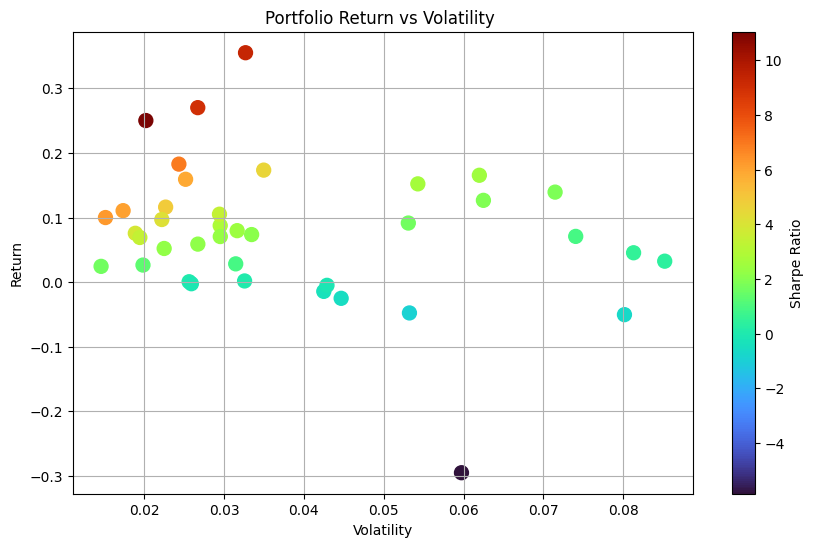


Stocks in Portfolio with Maximum Sharpe Ratio:
{'Date': Timestamp('2014-04-01 00:00:00'), 'Best Weights': array([0.02387281, 0.01333333, 0.03718726, 0.01322384, 0.01153976,
       0.02186094, 0.01887523, 0.02107333, 0.01310711, 0.01724899,
       0.01251476, 0.00180751, 0.02779928, 0.02492298, 0.00134283,
       0.02088647, 0.00352632, 0.03863268, 0.02559702, 0.01090724,
       0.02425385, 0.01231799, 0.00511932, 0.02459888, 0.00130768,
       0.03032823, 0.03903046, 0.05141164, 0.01398207, 0.04425225,
       0.0106246 , 0.03307694, 0.02168967, 0.0260364 , 0.00704693,
       0.03174537, 0.03260581, 0.01152902, 0.01793261, 0.04472323,
       0.00806476, 0.01833803, 0.0384195 , 0.02995008, 0.02339654,
       0.02700728, 0.00784427, 0.00410692]), 'Return': 0.2501840806906803, 'Volatility': 0.02021271046984592, 'Sharpe Ratio': 11.047049100985635, 'Symbols': array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'C

In [45]:
# Plotting the scatter plot with viridis colormap for Sharpe ratio using color-filled circles
returns = [portfolio['Return'] for portfolio in quarter_best_portfolios]
volatilities = [portfolio['Volatility'] for portfolio in quarter_best_portfolios]
sharpe_ratios = [portfolio['Sharpe Ratio'] for portfolio in quarter_best_portfolios]

plt.figure(figsize=(10, 6))
sc = plt.scatter(volatilities, returns, c=sharpe_ratios, cmap='turbo', s=100, marker='o')
plt.title('Portfolio Return vs Volatility ')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(sc, label='Sharpe Ratio')
plt.grid(True)
plt.show()

# Display the extracted non-zero weight stocks
print("\nStocks in Portfolio with Maximum Sharpe Ratio:")
print(max_sharpe_portfolio)

print("\nStocks in Portfolio with Minimum Sharpe Ratio:")
print(min_sharpe_portfolio)

print("\nStocks in Portfolio with Maximum Volatility:")
print(max_volatility_portfolio)

print("\nStocks in Portfolio with Minimum Volatility:")
print(min_volatility_portfolio)

# Calculate the percentage of quarters where the Sharpe ratio was greater than 1
sharpe_ratio_greater_than_1 = sum(1 for portfolio in quarter_best_portfolios if portfolio['Sharpe Ratio'] > 1)
total_quarters = len(quarter_best_portfolios)
percentage_sharpe_greater_than_1 = (sharpe_ratio_greater_than_1 / total_quarters) * 100
print(f"\nThe number of quarters where Sharpe ratio was greater than 1: {percentage_sharpe_greater_than_1:.2f}%")

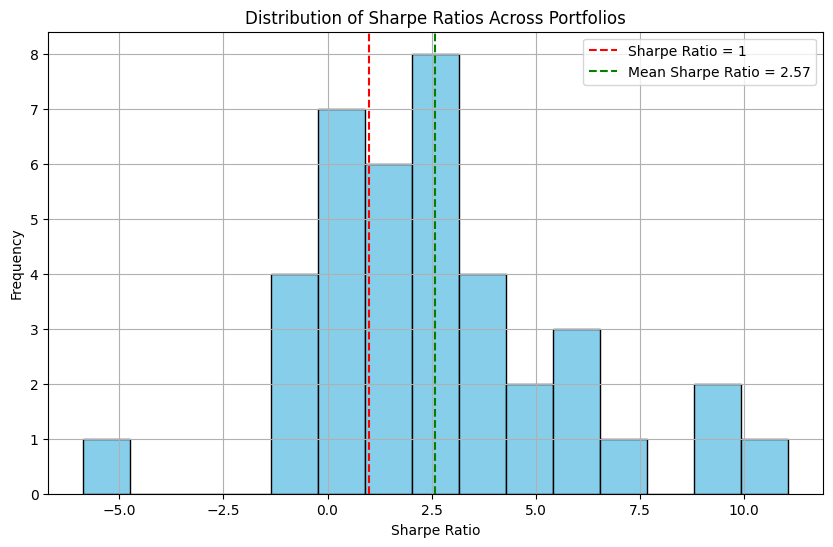

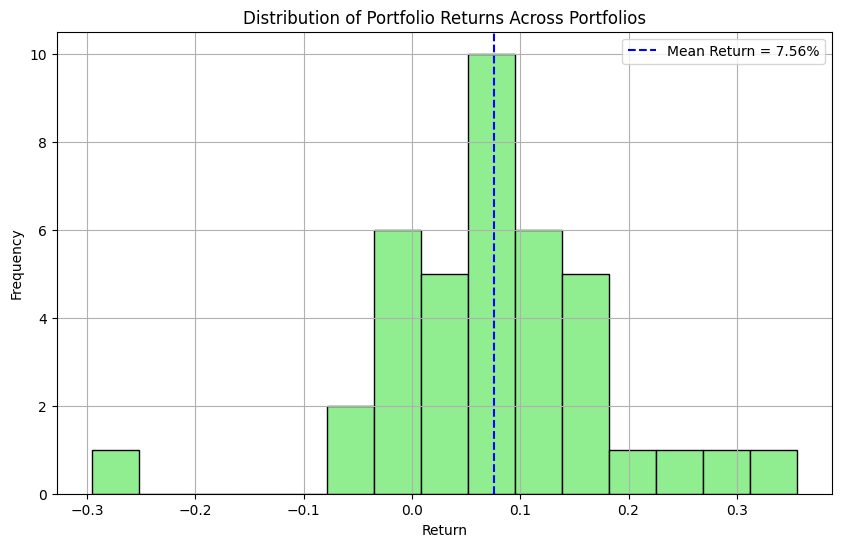

In [46]:
# calculating mean sharpe ratio and mean returns
sharpe_ratios_mean = np.mean(sharpe_ratios)
returns_mean = np.mean(returns)

# plotting the histogram for Sharpe ratio distribution with mean and Sharpe ratio = 1 line
plt.figure(figsize=(10, 6))
plt.hist(sharpe_ratios, bins=15, color='skyblue', edgecolor='black')
plt.axvline(x=1, color='red', linestyle='--', label='Sharpe Ratio = 1')
plt.axvline(x=sharpe_ratios_mean, color='green', linestyle='--', label=f'Mean Sharpe Ratio = {sharpe_ratios_mean:.2f}')
plt.title('Distribution of Sharpe Ratios Across Portfolios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the histogram for returns distribution with mean return line
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=15, color='lightgreen', edgecolor='black')
plt.axvline(x=returns_mean, color='blue', linestyle='--', label=f'Mean Return = {returns_mean:.2%}')
plt.title('Distribution of Portfolio Returns Across Portfolios')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

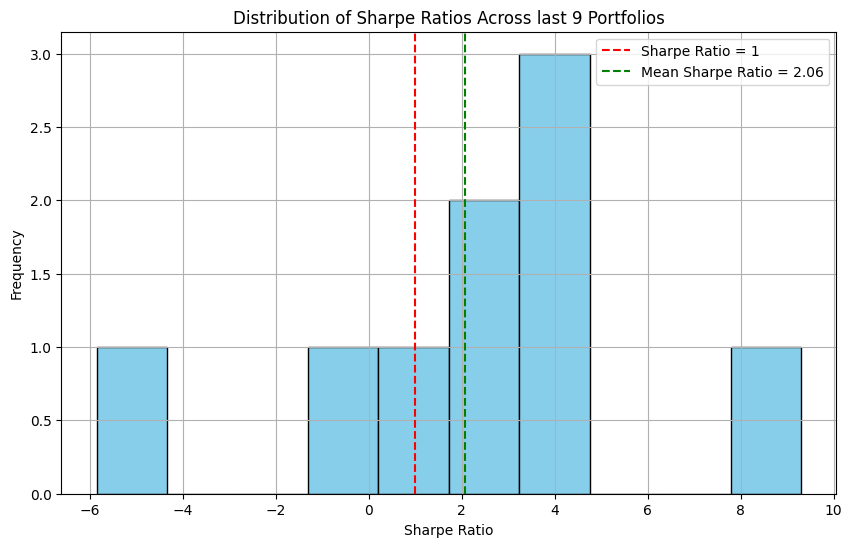

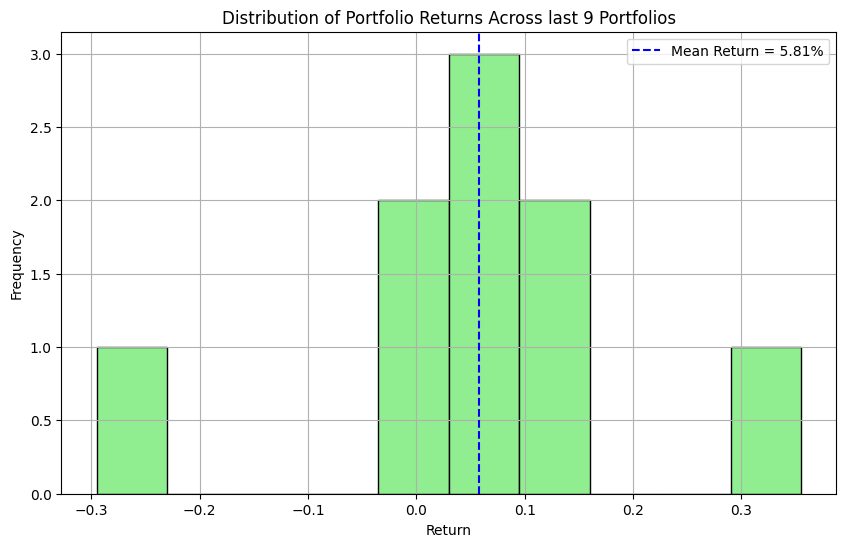

In [47]:
# calculating mean sharpe ratio and mean returns of last 9 portfolios for comparison
sharpe_ratios_mean_9_mcs = last_9_portfolios_mcs['Sharpe Ratio'].mean()
returns_mean_9_mcs = last_9_portfolios_mcs['Return'].mean()

# plotting the histogram for Sharpe ratio distribution with mean and Sharpe ratio = 1 line (last 9 portfolios)
plt.figure(figsize=(10, 6))
plt.hist(last_9_portfolios_mcs['Sharpe Ratio'], bins=10, color='skyblue', edgecolor='black')
plt.axvline(x=1, color='red', linestyle='--', label='Sharpe Ratio = 1')
plt.axvline(x=sharpe_ratios_mean_9_mcs, color='green', linestyle='--', label=f'Mean Sharpe Ratio = {sharpe_ratios_mean_9_mcs:.2f}')
plt.title('Distribution of Sharpe Ratios Across last 9 Portfolios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the histogram for returns distribution with mean return line (last 9 portfolios)
plt.figure(figsize=(10, 6))
plt.hist(last_9_portfolios_mcs['Return'], bins=10, color='lightgreen', edgecolor='black')
plt.axvline(x=returns_mean_9_mcs, color='blue', linestyle='--', label=f'Mean Return = {returns_mean_9_mcs:.2%}')
plt.title('Distribution of Portfolio Returns Across last 9 Portfolios')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Implementation of RL PPO algorithm

In [48]:
# pivot_returns_table_example = combined_data.pivot_table(
#             index='Date',
#             columns='Symbol',
#             values=[
#                 'quarterly_price_log_change',
#                 'Close',
#                 'quarterly_percent_price_change',
#                 'Basic EPS (Rs.)',
#                 'Net Profit/Loss For the Period (Cr.)',
#                 'dma_signal',
#                 'rsi_signal',
#                 'eps_signal',
#                 'profit_signal',
#                 'quarterly_eps_change',
#                 'quarterly_profit_change',
#                 '14_DRSI',
#                 '50_dma',
#                 '200_dma',
#                 'fundamental_technical_score'
#             ]
#         )
# print(pivot_returns_table_example)

In [49]:
# Define the custom environment for portfolio optimization
class PortfolioEnv(gym.Env):
    def __init__(self, returns_table):
        super(PortfolioEnv, self).__init__()

        self.returns_table = returns_table
        self.symbols = self.returns_table['Symbol'].unique()
        self.num_stocks = len(self.symbols)

        # Pivot the DataFrame to include relevant signals
        pivot_returns_table = self.returns_table.pivot_table(
            index='Date',
            columns='Symbol',
            values=[
                'quarterly_price_log_change',
                #'Close',
                #'quarterly_percent_price_change',
                #'Basic EPS (Rs.)',
                #'Net Profit/Loss For the Period (Cr.)',
                'dma_signal',
                'rsi_signal',
                #'eps_signal',
                #'profit_signal',
                'quarterly_eps_change',
                'quarterly_profit_change',
                #'14_DRSI',
                #'50_dma',
                #'200_dma'
                #'fundamental_technical_score'
            ]
        )

        scaler = MinMaxScaler()
        for feature in pivot_returns_table.columns.levels[0]:
            feature_data = pivot_returns_table[feature]
            scaled_data = scaler.fit_transform(feature_data)  # Scale the data for this feature
            pivot_returns_table[feature] = scaled_data  # Replace with scaled data

        # Calculate the covariance matrix for returns
        self.cov_matrix = pivot_returns_table['quarterly_price_log_change'].cov().values
        self.features = pivot_returns_table  # Store the pivot table to use for observations

        # Create a flattened list of column names (features) for easier reference
        self.stock_names = pivot_returns_table.columns.levels[1].tolist()
        num_features = len(pivot_returns_table.columns.levels[0])  # Number of features per stock

        # Adjust observation space to account for all signals across all stocks
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_stocks * num_features,), dtype=np.float32)

        # Action space is the allocation to each stock. Sum of allocations must be 1.
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_stocks,), dtype=np.float32)

        self.current_step = 0
        self.portfolio_value = 1.0  # Initial portfolio value
        self.weights = np.ones(self.num_stocks) / self.num_stocks  # Start with equal weights
        self.sharpe_ratios_rl = []
        self.portfolio_allocations_rl = []
        self.portfolio_return_rl = []
        self.portfolio_volatility_rl = []

    def reset(self):
        self.current_step = 0
        self.portfolio_value = 1.0
        self.weights = np.ones(self.num_stocks) / self.num_stocks
        self.sharpe_ratios_rl = []
        self.portfolio_allocations_rl = []
        self.portfolio_return_rl = []
        self.portfolio_volatility_rl = []
        return self._get_observation()

    def _get_observation(self):
        # Flatten the features for the current step to pass as an observation
        return self.features.iloc[self.current_step].values.flatten()

    def step(self, action):
        epsilon = 1e-8
        self.weights = action / (np.sum(action) + epsilon)  # Normalize to ensure the sum of weights is 1

        if self.current_step >= len(self.features.index) - 1:
            return np.zeros(self.observation_space.shape[0]), 0, True, {}

        # Calculate portfolio return for the next time period
        current_returns = self.features['quarterly_price_log_change'].iloc[self.current_step + 1].values
        portfolio_return = np.dot(current_returns, self.weights)
        self.portfolio_return_rl.append(portfolio_return)

        # Calculate portfolio volatility using the covariance matrix
        portfolio_volatility = np.sqrt(np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights)))  # Quarterly volatility
        self.portfolio_volatility_rl.append(portfolio_volatility)

        # Calculate Sharpe ratio (quarterly, not annualized)
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility != 0 else 0
        self.sharpe_ratios_rl.append(sharpe_ratio)

        # Store non-zero portfolio allocations
        allocation = {self.stock_names[i]: weight for i, weight in enumerate(self.weights) if weight > 0}
        self.portfolio_allocations_rl.append(allocation)

        self.current_step += 1

        done = self.current_step >= len(self.features.index) - 1 # last quarter return not calculated since data is not available and returns bool True
        obs = self._get_observation() if not done else np.zeros(self.observation_space.shape[0])

        return obs, sharpe_ratio, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}, Weights: {self.weights}")

    def get_sharpe_ratios_and_allocations(self):
        return self.sharpe_ratios_rl, self.portfolio_allocations_rl, self.portfolio_return_rl, self.portfolio_volatility_rl

# splitting to train and test
training_data = combined_data[combined_data['Date'] <= '2018-06-30']
test_data = combined_data[combined_data['Date'] > '2018-06-30']


# Create the environment for training
train_env = DummyVecEnv([lambda: PortfolioEnv(training_data)])
train_env.seed(seed)

policy_kwargs = dict(
    net_arch=[336, 128, 128, 48],  # define the number of neurons in each layer
    activation_fn=torch.nn.ReLU  # specifying activation function
)

# Define the PPO model
model = PPO(
    "MlpPolicy",          # Policy network type
    train_env,            # Environment
    policy_kwargs=policy_kwargs,  # custom policy network architecture
    learning_rate=1e-5,   # Learning rate
    n_steps=2048,         # Number of steps to collect per environment per update
    batch_size=64,        # Batch size
    n_epochs=50,          # Number of epochs
    clip_range=0.1,       # Clip range for PPO
    gamma=0.99,           # Discount factor
    gae_lambda=0.995,      # GAE lambda
    vf_coef=0.3,          # Value function coefficient
    ent_coef=0.05,        # Entropy coefficient
    max_grad_norm=0.5,    # Gradient clipping
    verbose=1,             # Verbosity level
    seed = seed
      )

# Train the PPO agent
model.learn(total_timesteps=200000)

# Create the environment for testing
test_environment = PortfolioEnv(test_data)

# Evaluate the trained model on the test data
obs = test_environment.reset()
sharpe_ratios_rl = []
portfolio_allocations_rl = []
returns_rl = []
volatilities_rl = []

for _ in range(len(test_data['Date'].unique()) - 1):  # Generate portfolios for each test quarter
    action, _states = model.predict(obs)
    obs, reward, done, info = test_environment.step(action)
    sharpe_ratios_rl.append(reward)
    portfolio_allocations_rl.append(test_environment.portfolio_allocations_rl[-1])
    volatilities_rl.append(test_environment.portfolio_volatility_rl[-1])
    returns_rl.append(test_environment.portfolio_return_rl[-1])
    if done:
        break


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


-----------------------------
| time/              |      |
|    fps             | 240  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 2            |
|    time_elapsed         | 33           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024397408 |
|    clip_fraction        | 0.0948       |
|    clip_range           | 0.1          |
|    entropy_loss         | -68.2        |
|    explained_variance   | -0.00146     |
|    learning_rate        | 1e-05        |
|    loss                 | 634          |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0109      |
|    std                  | 1            |
|    value_loss           | 6.06e+03     |
----------------

In [50]:
print("\nPortfolio Allocations for the test portfolios:")
for i, allocation in enumerate(portfolio_allocations_rl):
    print(f"Quarter {i + 1}:")
    for stock, weight in allocation.items():
        print(f"  {stock}: {weight:.4f}")
    print()

print("\n Returns, Volatilities, and Sharpe Ratios for the test portfolios:")
for i, (ret, vol, sharpe) in enumerate(zip(returns_rl, volatilities_rl, sharpe_ratios_rl)):
    print(f"Quarter {i + 1} - Return: {ret:.4f}, Volatility: {vol:.4f}, Sharpe Ratio: {sharpe:.4f}")


Portfolio Allocations for the test portfolios:
Quarter 1:
  ASIANPAINT: 0.0512
  AXISBANK: 0.0512
  BAJFINANCE: 0.0512
  DRREDDY: 0.0463
  GAIL: 0.0512
  GRASIM: 0.0512
  HCLTECH: 0.0370
  HDFCBANK: 0.0512
  ICICIBANK: 0.0512
  IOC: 0.0512
  ITC: 0.0512
  JSWSTEEL: 0.0446
  KOTAKBANK: 0.0379
  ONGC: 0.0105
  RELIANCE: 0.0512
  SBIN: 0.0512
  SHREECEM: 0.0024
  SUNPHARMA: 0.0183
  TCS: 0.0499
  TECHM: 0.0366
  TITAN: 0.0512
  WIPRO: 0.0512
  ZEEL: 0.0512

Quarter 2:
  ADANIPORTS: 0.0372
  ASIANPAINT: 0.0462
  AXISBANK: 0.0462
  BAJAJ-AUTO: 0.0462
  BAJFINANCE: 0.0462
  BHARTIARTL: 0.0462
  BPCL: 0.0462
  BRITANNIA: 0.0462
  CIPLA: 0.0383
  COALINDIA: 0.0185
  DRREDDY: 0.0106
  EICHERMOT: 0.0062
  GRASIM: 0.0462
  HCLTECH: 0.0017
  HDFCBANK: 0.0366
  ICICIBANK: 0.0462
  ITC: 0.0209
  JSWSTEEL: 0.0462
  KOTAKBANK: 0.0100
  ONGC: 0.0462
  POWERGRID: 0.0462
  SHREECEM: 0.0410
  SUNPHARMA: 0.0462
  TECHM: 0.0462
  TITAN: 0.0462
  VEDL: 0.0462
  WIPRO: 0.0403

Quarter 3:
  ASIANPAINT: 0.0298

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
dates = test_data['Date'].unique()
dates = dates[:-1]
sharpe_ratio_plotting_df_rl = pd.DataFrame({'Date': dates, 'Sharpe Ratio': sharpe_ratios_rl, 'Returns': returns_rl, 'Volatilities': volatilities_rl})

In [52]:
sharpe_ratio_plotting_df_rl

,Date,Sharpe Ratio,Returns,Volatilities
0,2018-07-02,3.184274,0.690231,0.216763
1,2018-10-01,2.523670,0.530642,0.210266
2,2019-01-01,3.390589,0.653935,0.192868
3,2019-04-01,2.601487,0.547680,0.210526
4,2019-07-01,2.197480,0.474420,0.215893
5,2019-10-01,2.878498,0.641732,0.222940
6,2020-01-01,0.649513,0.125675,0.193491
7,2020-04-01,4.403612,0.934089,0.212119
8,2020-07-01,3.356802,0.676392,0.201499


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


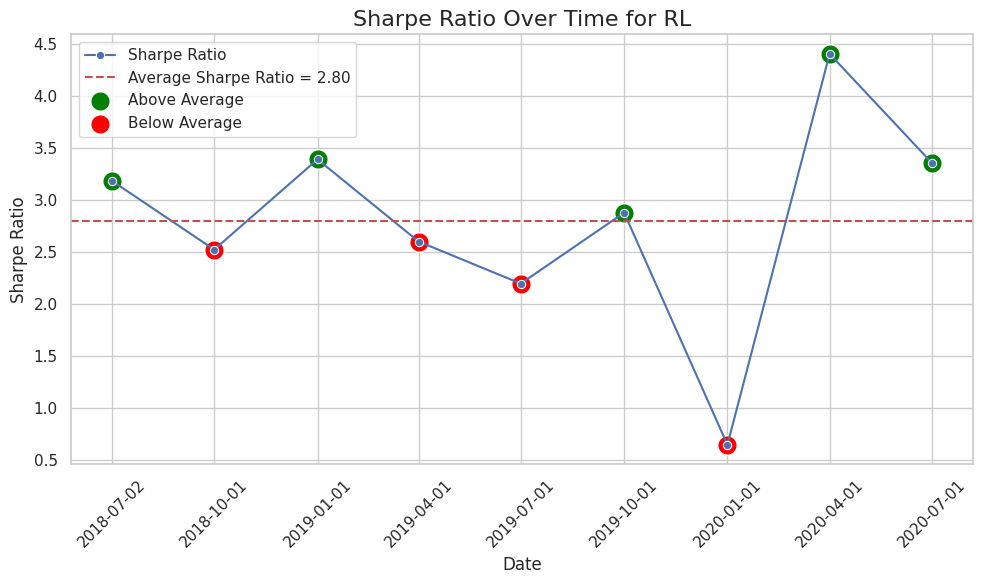

In [53]:

# Calculate the average Sharpe ratio
average_sharpe_ratio_rl = sharpe_ratio_plotting_df_rl['Sharpe Ratio'].mean()

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Sharpe Ratio', data=sharpe_ratio_plotting_df_rl, marker='o', color='b', label='Sharpe Ratio')

# Add the average Sharpe ratio line
plt.axhline(y=average_sharpe_ratio_rl, color='r', linestyle='--', label=f'Average Sharpe Ratio = {average_sharpe_ratio_rl:.2f}')

# Highlight points above and below the average
sns.scatterplot(x='Date', y='Sharpe Ratio', data=sharpe_ratio_plotting_df_rl[sharpe_ratio_plotting_df_rl['Sharpe Ratio'] > average_sharpe_ratio_rl], color='green', s=200, marker='o', label='Above Average')
sns.scatterplot(x='Date', y='Sharpe Ratio', data=sharpe_ratio_plotting_df_rl[sharpe_ratio_plotting_df_rl['Sharpe Ratio'] <= average_sharpe_ratio_rl], color='red', s=200, marker='o', label='Below Average')

# Formatting the x-axis to show quarters and years
plt.xticks(sharpe_ratio_plotting_df_rl['Date'], rotation=45)
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Over Time for RL', fontsize=16)
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


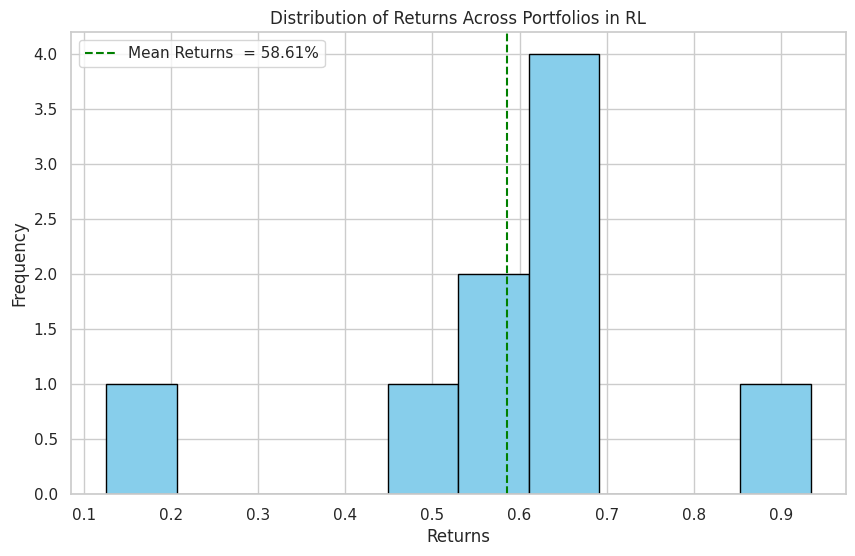

In [54]:
average_returns_mean_rl = sharpe_ratio_plotting_df_rl['Returns'].mean()


# plotting the histogram for Sharpe ratio distribution with mean and Sharpe ratio = 1 line
plt.figure(figsize=(10, 6))
plt.hist(sharpe_ratio_plotting_df_rl['Returns'], bins=10, color='skyblue', edgecolor='black')
plt.axvline(x=average_returns_mean_rl, color='green', linestyle='--', label=f'Mean Returns  = {average_returns_mean_rl:.2%}')
plt.title('Distribution of Returns Across Portfolios in RL')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()